### Preprocessing
The entire preprocessing pipeline from beginning to end, starting with the cropped images.

Kernel: indigene-img

In [2]:
# Required libraries
import os
import math
import pims
import bioformats
from natsort import natsorted
import torch
import torchvision
import random
import numpy as np
import pandas as pd
import skimage as ski
from PIL import Image
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
# from aicsimageio import AICSImage
from torchvision.io import read_image
from torchvision.utils import save_image
from torchvision.transforms import v2 as transforms

os.environ['JAVA_HOME'] = '/hps/nobackup/birney/users/esther/Fiji.app/java/linux-amd64/zulu8.60.0.21-ca-fx-jdk8.0.322-linux_x64/jre/'

In [3]:
torch.manual_seed(1)

In [4]:
print(torch.version.cuda)

12.1


In [5]:
# Get the current working directory of the script
print(os.getcwd())

/nfs/research/birney/users/esther/medaka-img/scripts


### Load one image as a test

(980, 1392, 3)
uint8


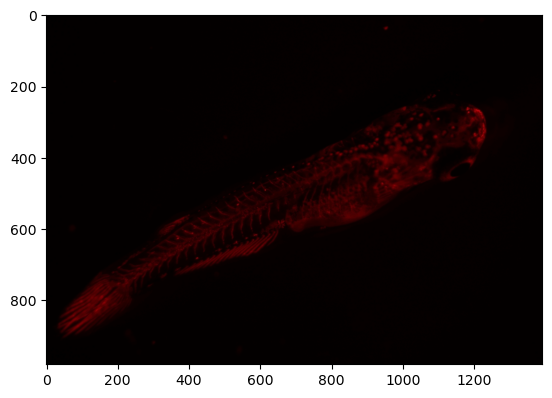

Min pixel value:  0
Max pixel value:  192


In [6]:
test_file = '../cropped_images/PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A12.tif'
test_image = ski.io.imread(test_file)

print(test_image.shape)
print(test_image.dtype)

test_image_plot = plt.imshow(test_image)
plt.show()

print("Min pixel value: ", np.min(test_image))
print("Max pixel value: ", np.max(test_image))

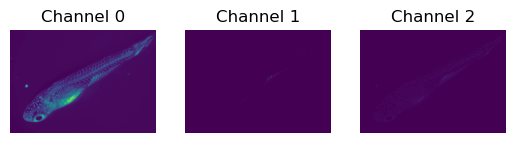

In [90]:
# Plot all three colour channels of the raw image
fig, axs = plt.subplots(1,3)

for i in [0, 1, 2]:
    axs[i].imshow(test_image[:,:,i])
    axs[i].set_title('Channel ' + str(i))
    axs[i].axis('off')

plt.show()

Since only channel 0 has any data, use only this colour channel for the rest of the preprocessing

Min pixel value:  0
Max pixel value:  192


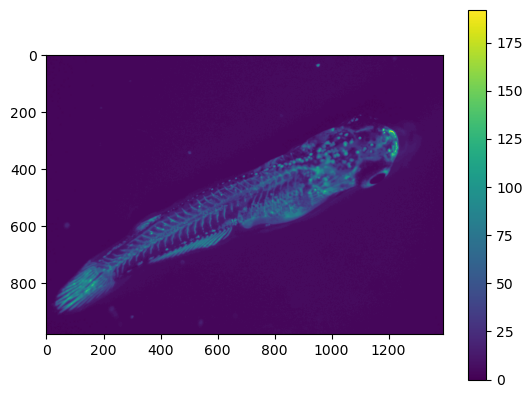

In [72]:
plt.imshow(test_image[:,:,0])
plt.colorbar()

print("Min pixel value: ", np.min(test_image[:,:,0]))
print("Max pixel value: ", np.max(test_image[:,:,0]))

### Within-image pixel intensity normalization

In [6]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,255] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min()) * 255

In [7]:
transform = transforms.Compose([
    # transforms.ToImage(), # Convert to PIL image
    transforms.ToDtype(torch.float32, scale=True), # Convert to float32; use instead of deprecated ToTensor()
    MinMaxScaling()
])

Min pixel value:  0.0
Max pixel value:  255.0
<class 'numpy.ndarray'>


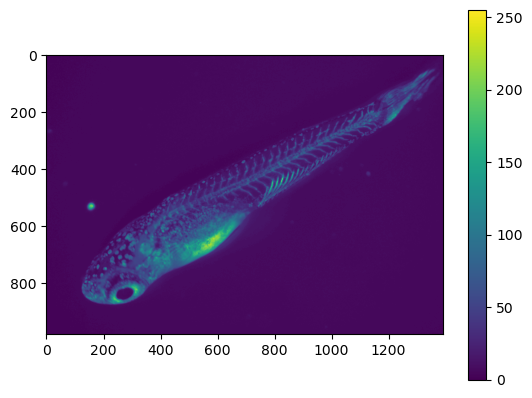

In [6]:
test_image_normalized = transform(test_image[:,:,0])
plt.imshow(test_image_normalized)
plt.colorbar()

print("Min pixel value: ", np.min(test_image_normalized))
print("Max pixel value: ", np.max(test_image_normalized))

print(type(test_image_normalized))

#### Transform and save all raw (but cropped) images to single-channel, normalized images
Can't save them as greyscale; constrast too low

In [ ]:
# normalized_1channel_dir = '/nfs/research/birney/users/esther/medaka-img/normalized_1channel_images'
# if not os.path.exists(normalized_1channel_dir):
#     os.makedirs(normalized_1channel_dir)

# list_files = os.listdir(path = '/nfs/research/birney/users/esther/medaka-img/cropped_images/')
# print(len(list_files))

# for file in natsorted(list_files):
#     if file.endswith('.tif'):
#         image = ski.io.imread('/nfs/research/birney/users/esther/medaka-img/cropped_images/' + file)
#         image_normalized = transform(image[:,:,0])
#         ski.io.imsave(normalized_1channel_dir + '/' + file, image_normalized.astype(np.uint16))
#     else:
#         print('File ' + file + ' is not a .tif file')
#         continue

### Get image mask

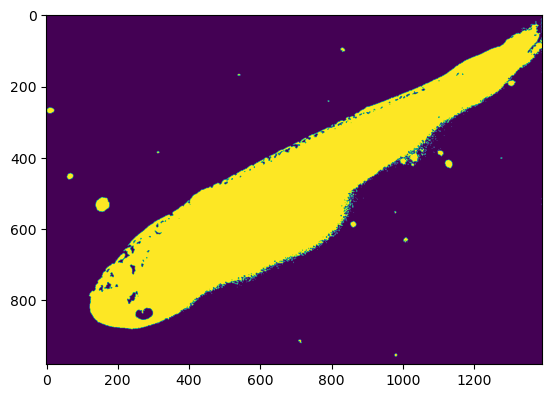

In [7]:
plt.imshow(test_image_normalized > 10)

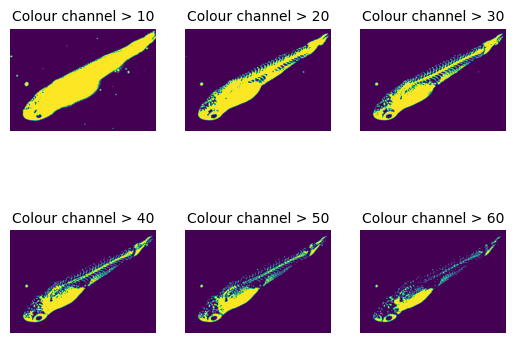

In [85]:
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.imshow(test_image_normalized > i*10)
    plt.subplot(2,3,i).set_title('Colour channel > ' + str(i*10), fontsize=10)
    plt.axis('off')

plt.show()

#### Read in the dataframe which indicates if a fish is left-facing; if left-facing, flip after normalization

In [48]:
left_facing_df = pd.read_csv('/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv',
                            index_col = 0) # Use first column (sample names) as index
left_facing_df = left_facing_df.iloc[:, [1]] # Remove unneeded 'left_vs_right' column
left_facing_df = left_facing_df[left_facing_df['left_facing'] == 'left']

print(left_facing_df.index.tolist()[1:10])

left_facing_df_index = left_facing_df.index.tolist()

['PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_E6', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_E9', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_E10', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_F1', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_F2', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_F3', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_F9', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_F11', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_G1']


In [ ]:
# Flip all the left-facing cropped images
cropped_flipped_dir = '/nfs/research/birney/users/esther/medaka-img/cropped_flipped_images'
if not os.path.exists(cropped_flipped_dir):
    os.makedirs(cropped_flipped_dir)

list_files = os.listdir(path = '/nfs/research/birney/users/esther/medaka-img/cropped_images/')
print(len(list_files))

for file in natsorted(list_files):
    if file.endswith('.tif'):
        image = ski.io.imread('/nfs/research/birney/users/esther/medaka-img/cropped_images/' + file)
        if (os.path.splitext(file)[0] in left_facing_df.index.tolist()):
            image = transforms.functional.hflip(Image.fromarray(image))
        ski.io.imsave(cropped_flipped_dir + '/' + file, np.array(image))
    else:
        print('File ' + file + ' is not a .tif file')
        continue

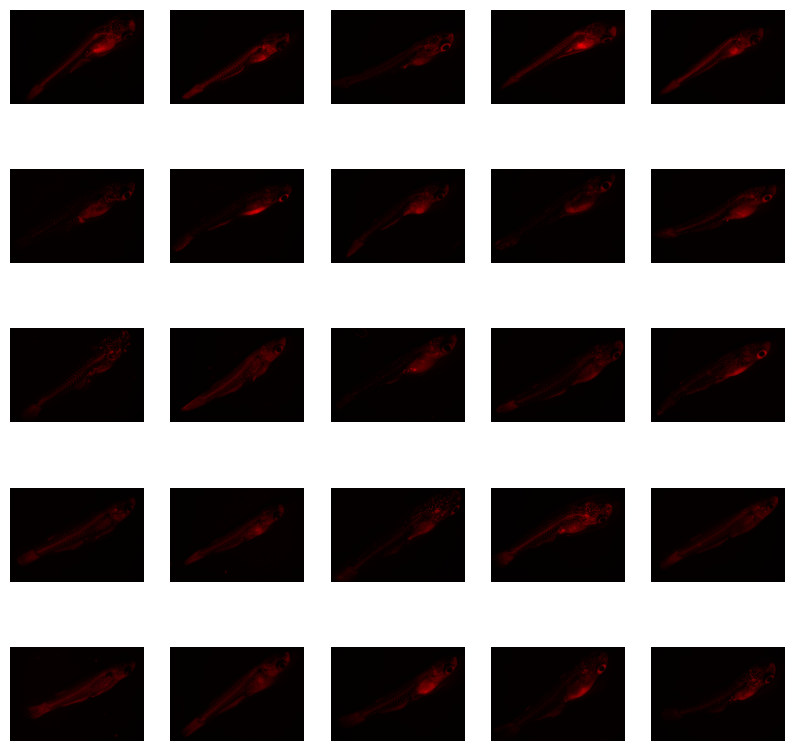

In [71]:
cropped_flipped_files = [f for f in os.listdir(cropped_flipped_dir) if f.endswith('.tif')]
selected_images = random.sample(cropped_flipped_files, 25)

fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for i, ax in enumerate(axs.flat):
    img = Image.open(os.path.join(cropped_flipped_dir, selected_images[i]))
    ax.imshow(img)
    ax.axis('off')

plt.show()

#### Transform and save all image masks using colour channel > 15

In [54]:
mask_dir = '/nfs/research/birney/users/esther/medaka-img/masked_images'
if not os.path.exists(mask_dir):
    os.makedirs(mask_dir)

list_files = os.listdir(path = '/nfs/research/birney/users/esther/medaka-img/cropped_flipped_images/')
print(len(list_files))

for file in natsorted(list_files):
    if file.endswith('.tif'):
        image = ski.io.imread('/nfs/research/birney/users/esther/medaka-img/cropped_flipped_images/' + file)
        image_normalized = transform(image[:,:,0])
        image_mask = image_normalized > 15
        ski.io.imsave(mask_dir + '/' + file, ski.util.img_as_ubyte(image_mask))
    else:
        print('File ' + file + ' is not a .tif file')
        continue

2353


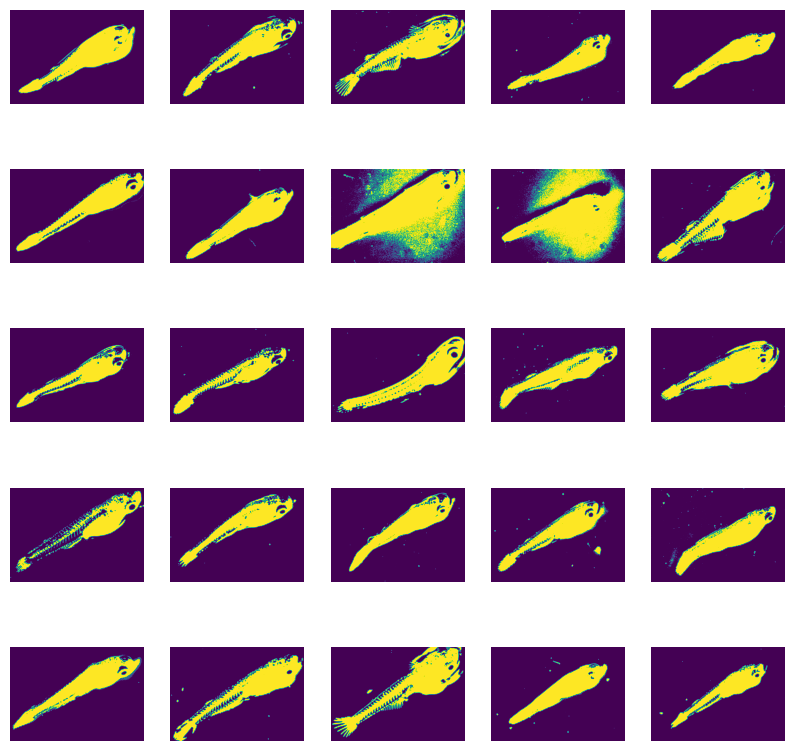

['PLATE 20 F2 VC_ Male 95-1 F14 x Female 33-1 F14_B10.tif', 'PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_A10.tif', 'PLATE 5 F2 VC_Tank bottom Male 14-2 F14 x Female 72-1 F14_G2.tif', 'PLATE 15 F2 VC_ Female 14-2 F14 x Male 10-1 F14_H10.tif', 'PLATE 20 F2 VC_ Male 95-1 F14 x Female 33-1 F14_H11.tif', 'PLATE 23 F2 VC_ Male 14-2 F14 x Female 10-1 F14_D3.tif', 'PLATE 20 F2 VC_ Male 95-1 F14 x Female 33-1 F14_B9.tif', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_B09.tif', 'PLATE 14 F2 VC_ Female 95-1 F14 x Male 33-1 F14_B10.tif', 'PLATE 4 F2 VC_Male 95-1 F14 x Female 129-1 F14_H4.tif', 'PLATE 17 F2 VC_ Male 14-2 F14 x Female 60-1 F14_D12.tif', 'PLATE 16 F2 VC_ Female 14-2 F14 x Male 10-1 F14_E1.tif', 'PLATE 6 F2 VC_ Male 14-2 F14 x Female 72-1 F14_D6.tif', 'PLATE 10 F2 VC_ Female 14-2 F14 x Male 33-1 F14_G11.tif', 'PLATE 14 F2 VC_ Male 95-1 F14 x Female 10-1 F14_H1.tif', 'PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_D4.tif', 'PLATE 23 F2 VC_ Male 11-2 F14 x Female 14-2 F14_F3.tif', '

In [53]:
# Plot a random subset of the masks
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.tif')]
selected_images = random.sample(mask_files, 25)

fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for i, ax in enumerate(axs.flat):
    img = Image.open(os.path.join(mask_dir, selected_images[i]))
    ax.imshow(img)
    ax.axis('off')

plt.show()

print(selected_images)

### Images were aligned using VOTj plugin for FIJI -- visualize a random subset

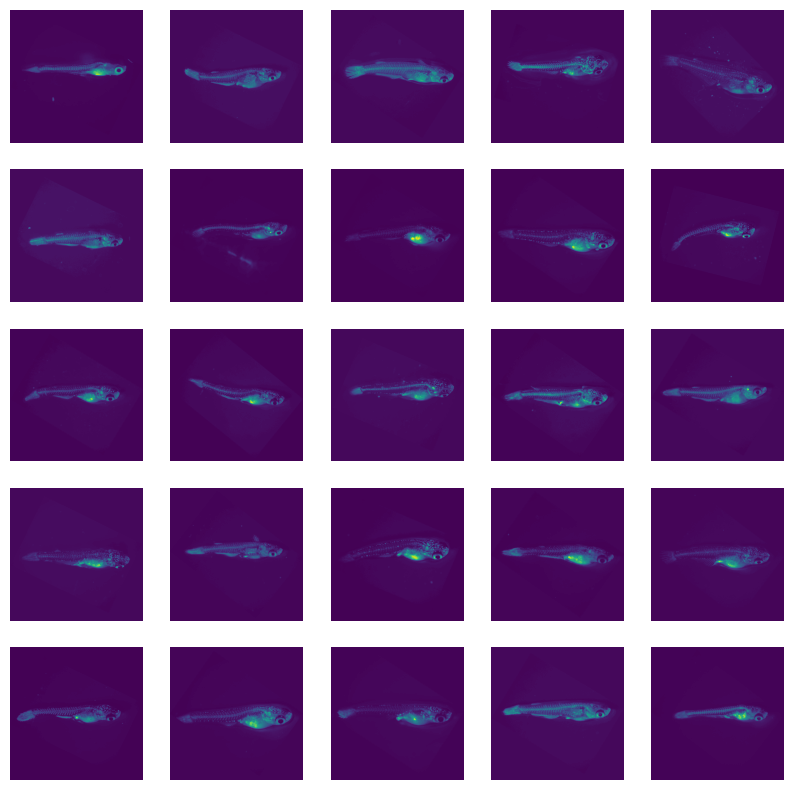

['PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D11.tif-aligned.tif', 'PLATE 16 F2 VC_ Male 14-2 F14 x Female 10-1 F14_E5.tif-aligned.tif', 'PLATE 16 F2 VC_ Female 14-2 F14 x Male 129-1 F14_G11.tif-aligned.tif', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_D11.tif-aligned.tif', 'PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_A5.tif-aligned.tif', 'PLATE 18 F2 VC_ Female 14-2 F14 x Male 33-1 F14_E11.tif-aligned.tif', 'PLATE 7 F2 VC_ Female 95-1 F14 x Male 72-1 F14_Tank bottom_A5.tif-aligned.tif', 'PLATE 22 F2 VC_ Female 14-2 F14 x Male 60-1 F14_D10.tif-aligned.tif', 'PLATE 12 F2 VC_ Female 14-2 F14 x Male 129-1 F14_D5.tif-aligned.tif', 'PLATE 11 F2 VC_ Male 14-2 F14 x Female 33-1 F14_B8.tif-aligned.tif', 'PLATE 10 F2 VC_ Male 14-2 F14 x Female 10-1 F14_G7.tif-aligned.tif', 'PLATE 16 F2 VC_ Female 14-2 F14 x Male 10-1 F14_A10.tif-aligned.tif', 'PLATE 10 F2 VC_ Female 95-1 F14 x Male 72-1 F14_C6.tif-aligned.tif', 'PLATE 19 F2 VC_ Female 95-1 F14 x Male 10-1 F14_H8.tif-aligned.tif', 'PLA

In [3]:
# Plot a random subset of the VOTJ outputs
votj_dir = '/nfs/research/birney/users/esther/medaka-img/votj_aligned_images'

votj_files = [f for f in os.listdir(votj_dir) if f.endswith('.tif')]
selected_images = random.sample(votj_files, 25)

fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for i, ax in enumerate(axs.flat):
    img = Image.open(os.path.join(votj_dir, selected_images[i]))
    ax.imshow(img.split()[0]) # Show only the first colour channel for higher contrast
    ax.axis('off')

plt.show()
print(selected_images)

### After using VOTj to align the fish horizontally, check a random subset of the VOTj output images

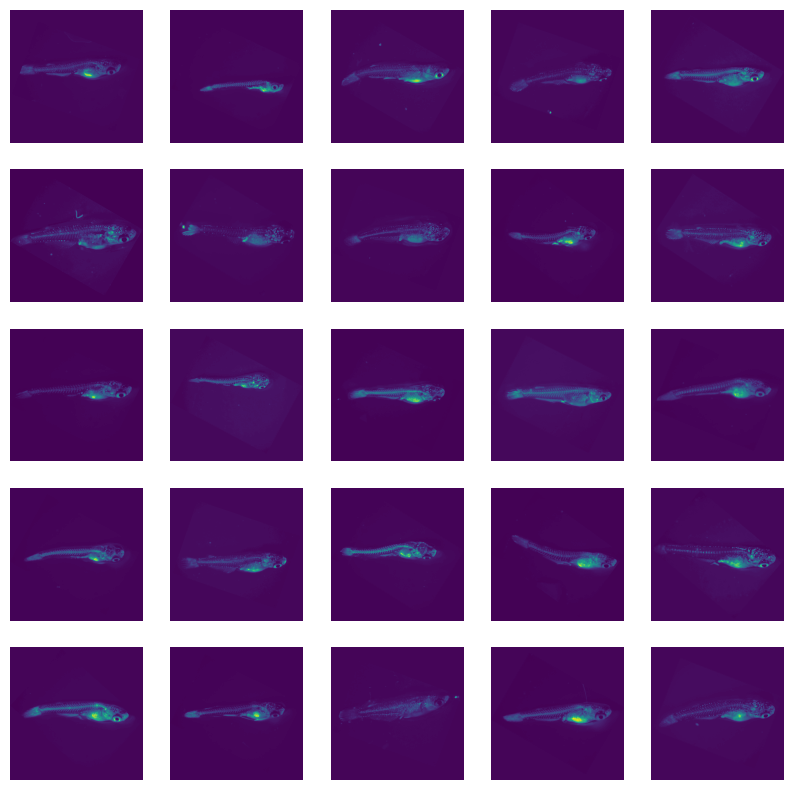

['PLATE 17 F2 VC_ Male 14-2 F14 x Female 60-1 F14_G1.tif-aligned.tif', 'PLATE 10 F2 VC_ Male 95-1 F14 x Female 72-1 F14_D9.tif-aligned.tif', 'PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_H9.tif-aligned.tif', 'PLATE 9 F2 VC_ Female 14-2 F14 x Male 10-1 F14_G3.tif-aligned.tif', 'PLATE 9 F2 VC_ Female 14-2 F14 x Male 33-1 F14_A9.tif-aligned.tif', 'PLATE 3 F2 VC_Female 14-2 F14 x Male 72-1 F14_A10.tif-aligned.tif', 'PLATE 3 F2 VC_Male 14-2 F14 x Female 72-1 F14_H6.tif-aligned.tif', 'PLATE 10 F2 VC_ Male 95-1 F14 x Female 129-1 F14_E2.tif-aligned.tif', 'PLATE 9 F2 VC_ Male 14-2 F14 x Female 33-1 F14_C11.tif-aligned.tif', 'PLATE 8 F2 VC_ Male 95-1 F14 x Female 10-1 F14_A2.tif-aligned.tif', 'PLATE 12 F2 VC_ Male 14-2 F14 x Female 33-1 F14_B3.tif-aligned.tif', 'PLATE 12 F2 VC_ Female 14-2 F14 x Male 129-1 F14_C6.tif-aligned.tif', 'PLATE 19 F2 VC_ Male 95-1 F14 x Female 10-1 F14_G9.tif-aligned.tif', 'PLATE 15 F2 VC_ Female 14-2 F14 x Male 60-1 F14_H2.tif-aligned.tif', 'PLATE 23 F2 VC_ Male 11

In [14]:
votj_final_dir = '/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any'

votj_final_files = [f for f in os.listdir(votj_final_dir) if f.endswith('.tif')]
selected_images = random.sample(votj_final_files, 25)

fig, axs = plt.subplots(5, 5, figsize = (10, 10))

for i, ax in enumerate(axs.flat):
    img = Image.open(os.path.join(votj_final_dir, selected_images[i]))
    ax.imshow(img.split()[0]) # Show only the first colour channel for higher contrast
    ax.axis('off')

plt.show()
print(selected_images)

# votj_aligned_images_align_any returns pretty consistently left-facing fish
# votj_aligned_images_flip_centered returns a motley of left/right-facing fish

### Get pixel size of fish using `regionprops`

In [8]:
test_image.shape

(1702, 1702, 3)

row_number:  25


,centroid-0,centroid-1,orientation,axis_major_length,axis_minor_length,bbox-0,bbox-1,bbox-2,bbox-3
25,743.555249,930.418889,-1.566848,1281.600783,237.767097,551,155,877,1491


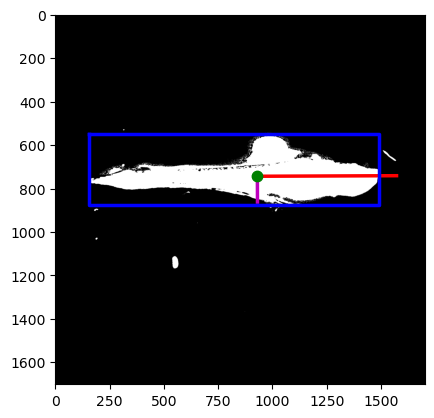

In [2]:
test_image = ski.io.imread('/nfs/research/birney/users/esther/medaka-img/votj_aligned_images_align_any/PLATE 25 F2 VC_ Male 11-2 F15 x Female 72-1 F14_D11.tif-aligned.tif')

label_test_img = ski.measure.label(test_image[:,:,0] > 10)

regions_df = pd.DataFrame(ski.measure.regionprops_table(label_test_img, properties = ('centroid', 'orientation', 'axis_major_length', 'axis_minor_length', 'bbox')))
# display(regions_df)

row_number = regions_df['axis_major_length'].idxmax()
print("row_number: ", row_number)

display(regions_df.iloc[row_number:row_number + 1])

regions = ski.measure.regionprops(label_test_img)[row_number:row_number + 1]

fig, ax = plt.subplots()
ax.imshow(test_image[:,:,0] > 10, cmap = plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-m', linewidth=2.5) # Plot minor axis
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5) # Plot major axis
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)


In [64]:
math.pi/2

1.5707963267948966

### Get metadata

In [3]:
images = pims.open('../all_images/PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_E04.tif')
reader = pims.Bioformats('../all_images/PLATE 1 F2 VC_Female 95-1 F14 x Male 129-1 F14_E04.tif', meta = True, java_memory='2048m')

In [7]:
reader = pims.ReaderSequence('../all_images/*.tif', pims.Bioformats, java_memory='2048m')

In [10]:
print(reader[0].metadata['mpp'])
print(reader)

42.333333333333336
<ReaderSequence>
Source: /nfs/research/birney/users/esther/medaka-img/all_images/*.tif
Axes: 4
Axis 'x' size: 1392
Axis 'y' size: 1040
Axis 'c' size: 3
Axis 't' size: 2353
Pixel Datatype: u1


In [3]:
pixel_size = []
for i in range(0,2353):
    if (i != 83):
        pixel_size = pixel_size + [reader[i].metadata['mpp']]

In [4]:
print(set(pixel_size))

{42.333333333333336}


In [ ]:
len(pixel_size)

In [26]:
meta = reader.metadata
print(meta.PixelsPhysicalSizeX(0))
print(meta.PixelsPhysicalSizeY(0))

<MetadataRetrieve> Available loci.formats.meta.MetadataRetrieve functions: ChannelAnnotationRefCount, ChannelCount, ChannelID, ChannelSamplesPerPixel, DatasetCount, ExperimentCount, ExperimenterCount, ExperimenterGroupCount, FolderCount, ImageAnnotationRefCount, ImageCount, ImageID, ImageName, ImageROIRefCount, InstrumentCount, LightPathAnnotationRefCount, LightPathEmissionFilterRefCount, LightPathExcitationFilterRefCount, MicrobeamManipulationRefCount, PixelsBigEndian, PixelsBinDataCount, PixelsDimensionOrder, PixelsID, PixelsInterleaved, PixelsPhysicalSizeX, PixelsPhysicalSizeY, PixelsSignificantBits, PixelsSizeC, PixelsSizeT, PixelsSizeX, PixelsSizeY, PixelsSizeZ, PixelsType, PlaneCount, PlateCount, ProjectCount, ROICount, ResolutionCount, ScreenCount, TiffDataCount
42.333333333333336
42.333333333333336
0
3
Channel:0:0
1
0


In [27]:
meta = reader.get_metadata_raw()
print(meta)

{'XResolution': '600.0', 'PhotometricInterpretation': 'RGB', 'PlanarConfiguration': 'Chunky', 'MetaDataPhotometricInterpretation': 'RGB', 'NewSubfileType': '2', 'ImageLength': '1040', 'BitsPerSample': '8', 'ResolutionUnit': 'Inch', 'Compression': 'Uncompressed', 'SamplesPerPixel': '3', 'NumberOfChannels': '3', 'MetaMorph': 'no', 'ImageWidth': '1392', 'Orientation': '1st row -> top; 1st column -> left', 'PageNumber': '0 0', 'YResolution': '600.0'}


In [14]:
raw_images = os.listdir("/nfs/research/birney/users/esther/medaka-img/all_images/")
filtered_raw_images = []

for file in raw_images:
    if (".tif" in file) and ("4channel" not in file):
        filtered_raw_images = filtered_raw_images + [file]

print(len(raw_images))
print(len(filtered_raw_images))
print(filtered_raw_images[0:10])

2355
2353
['PLATE 11 F2 VC_ Female 14-2 F14 x Male 60-1 F14_E7.tif', 'PLATE 13 F2 VC_ Male 95-1 F14 x Female 33-1 F14_E10.tif', 'PLATE 23 F2 VC_ Male 14-2 F14 x Female 10-1 F14_D2.tif', 'PLATE 6 F2 VC_ Male 95-1 F14 x Female 72-1 F14_F1.tif', 'PLATE 19 F2 VC_ Male 14-2 F14 x Female 33-1 F14_A12.tif', 'PLATE 23 F2 VC_ Male 14-2 F14 x Female 10-1 F14_B7.tif', 'PLATE 19 F2 VC_ Male 14-2 F14 x Female 33-1 F14_A5.tif', 'PLATE 13 F2 VC_ Male 95-1 F14 x Female 33-1 F14_D11.tif', 'PLATE 2 F2 VC_Female 95-1 F14 x Male 129-1 F14_G1.tif', 'PLATE 8 F2 VC_ Male 14-2 F14 x Female 60-1 F14_H8.tif']


### Get number of pixels for each image

In [47]:
def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width, height

In [53]:
num_pixels = []
for image in filtered_raw_images:
    num_pixels = num_pixels + [tuple(get_num_pixels("/nfs/research/birney/users/esther/medaka-img/all_images/" + image))]

In [60]:
print(set(num_pixels))
print(len(num_pixels))

{(1392, 1040)}
2353


### Get pixel size for each image

In [24]:
import imageio.v3 as iio

def get_size_pixels(filepath):
    width, height = iio.improps(filepath,  extension=".tif").spacing
    return [width, height]

In [58]:
size_pixels = []
for image in filtered_raw_images:
    size_pixels = size_pixels + [tuple(get_size_pixels("/nfs/research/birney/users/esther/medaka-img/all_images/" + image))]

In [61]:
# print(size_pixels)
print(set(size_pixels))
print(len(size_pixels))

{(600.0, 600.0)}
2353


### ignore

In [84]:
# Python solution from https://forum.image.sc/t/reading-pixel-size-from-image-file-with-python/74798/3

img = AICSImage('/nfs/research/birney/users/esther/medaka-img/all_images/PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif')
print(img.physical_pixel_sizes)
print(img.physical_pixel_sizes.X) # 42.333333333333336 (mm = 0.016666667 inch)
print(img.physical_pixel_sizes.Y) # 42.333333333333336 (mm)

print(img.metadata)

PhysicalPixelSizes(Z=None, Y=42.333333333333336, X=42.333333333333336)
42.333333333333336
42.333333333333336
{254: <FILETYPE.PAGE: 2>, 256: 1392, 257: 1040, 258: (8, 8, 8), 259: <COMPRESSION.NONE: 1>, 262: <PHOTOMETRIC.RGB: 2>, 273: (268, 1048444, 2096620, 3144796, 4192972), 274: <ORIENTATION.TOPLEFT: 1>, 277: 3, 278: 251, 279: (1048176, 1048176, 1048176, 1048176, 150336), 282: (600, 1), 283: (600, 1), 284: <PLANARCONFIG.CONTIG: 1>, 296: <RESUNIT.INCH: 2>, 297: (0, 0)}


In [83]:
with Image.open('/nfs/research/birney/users/esther/medaka-img/all_images/PLATE 1 F2 VC_Female 95-1 F14 x Male 72-1 F14_A01.tif') as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}

print(meta_dict)

{'ImageWidth': (1392,), 'ImageLength': (1040,), 'BitsPerSample': (8, 8, 8), 'Compression': (1,), 'PhotometricInterpretation': (2,), 'StripOffsets': (268, 1048444, 2096620, 3144796, 4192972), 'Orientation': (1,), 'SamplesPerPixel': (3,), 'RowsPerStrip': (251,), 'StripByteCounts': (1048176, 1048176, 1048176, 1048176, 150336), 'XResolution': ((600, 1),), 'YResolution': ((600, 1),), 'PlanarConfiguration': (1,), 'ResolutionUnit': (2,), 'PageNumber': (0, 0), 'NewSubfileType': (2,)}
